In [10]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

from pca import pca
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

In [2]:
df = pd.read_hdf('2_Cleaned_dataset/images.h5', key='data')
df.shape

(910, 10)

## Predicción

In [63]:
def get_dataset(column='image'):
    # Aplanamos las imágenes antes de crear una matriz de valores estandarizados
    X = np.stack(df[column].apply(lambda x: x.flatten()))
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Crea un DataFrame a partir de los datos escalados
    X_standardized_df = pd.DataFrame(X_standardized)

    pca_model = PCA(n_components=700)
    pca_model.fit(X_standardized_df)
    return pca_model.transform(X_standardized_df)
    

In [60]:
def show_images(column = 'image', c_labels='kmeans_label'):
    for c in range(4):
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 5))
        df_sample = df[df[c_labels] == c].sample(n=25)
        fig.suptitle(f'Grupo {c}')

        for i, ax in enumerate(axes.flat):
            ax.imshow((df_sample[i:i+1][column].values[0]), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()

In [70]:
def predict(column='image', c_labels='kmeans_label'):
    orth_pca = get_dataset(column)
    kmeans_orth_pca = KMeans(n_clusters=4, random_state=123, n_init=10, max_iter=100)
    kmeans_orth_pca.fit(orth_pca)
    
    iterations_faces_pca = kmeans_orth_pca.n_iter_
    print(f"Cantidad de iteraciones realizadas: {iterations_faces_pca}")

    df[c_labels] = kmeans_orth_pca.labels_


Cantidad de iteraciones realizadas: 3


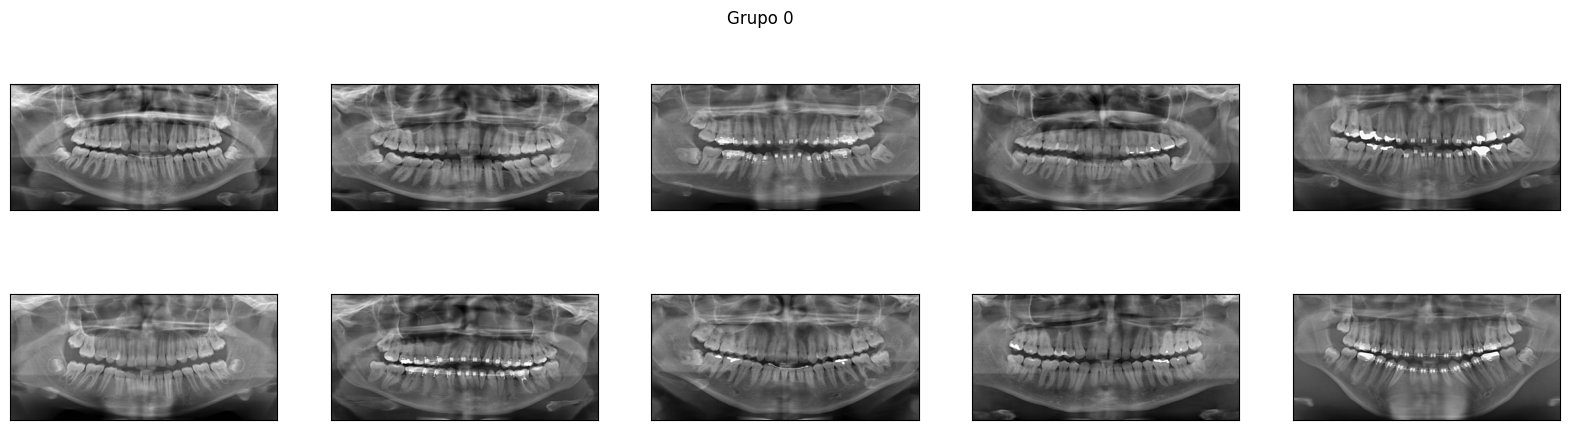

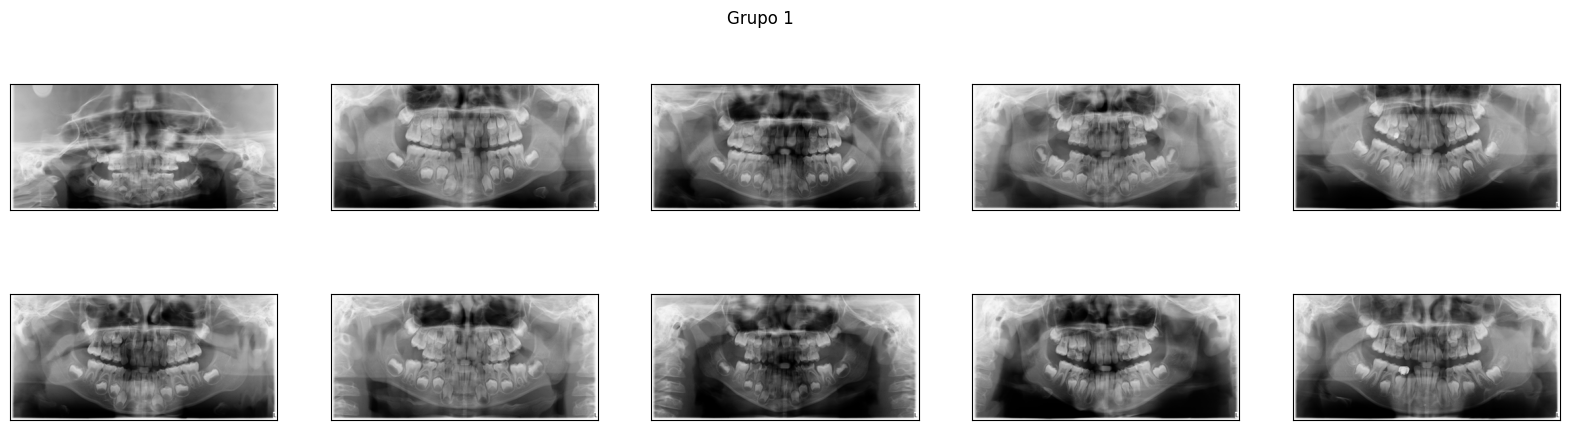

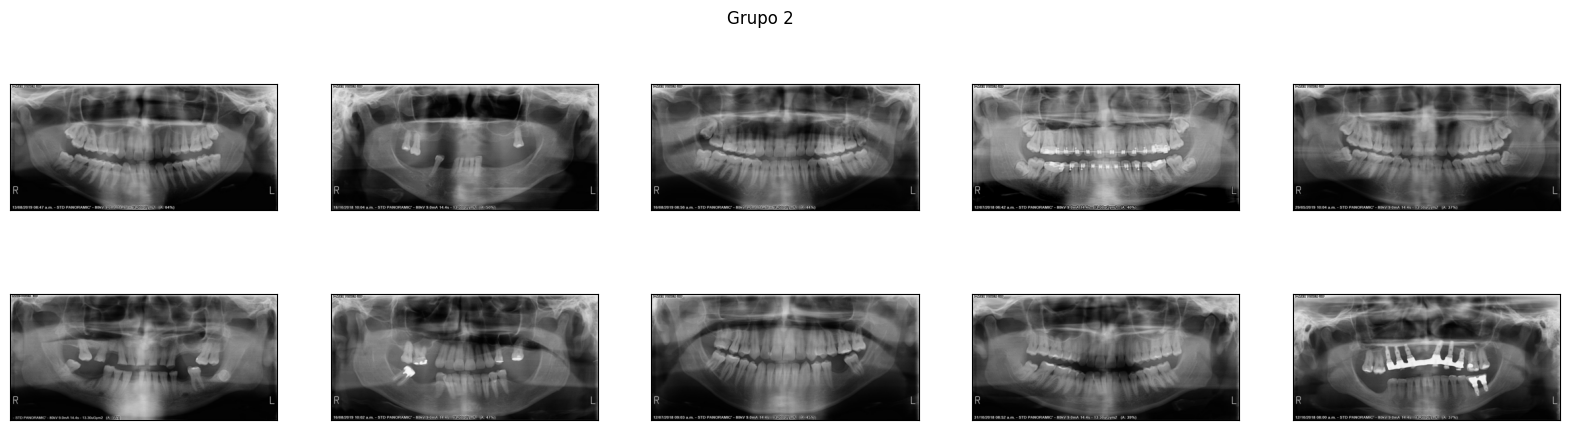

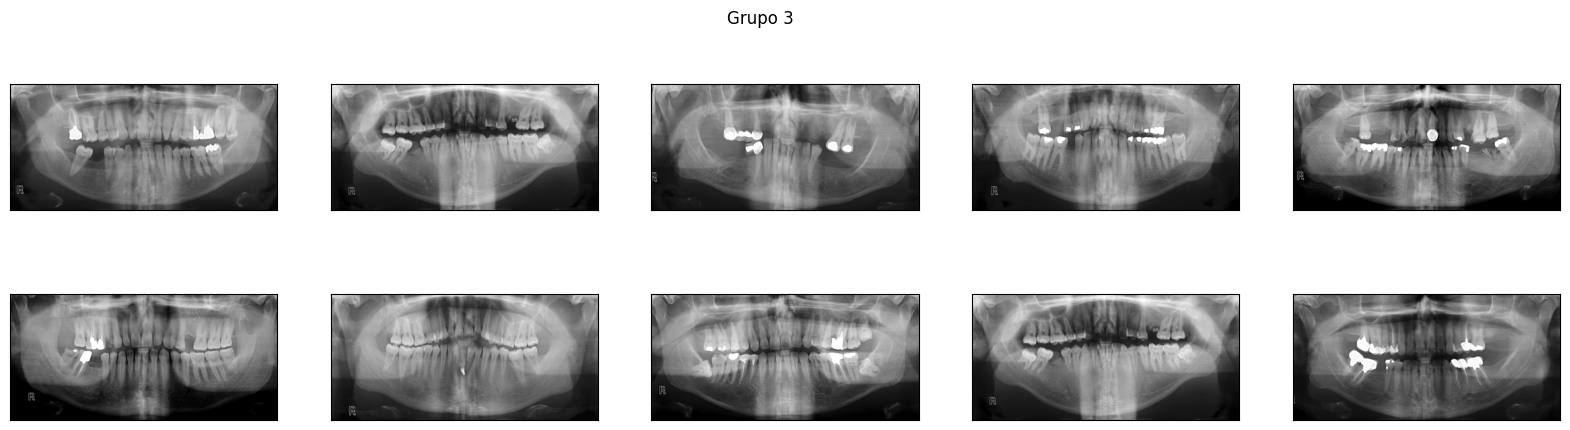

In [64]:
predict()


In [38]:
pd.set_option('display.max_columns', 500)

## Predcción aplicando filtro sabel

**** ME GUSTA COMO PREDICE EL GRUPO QUE NO TIENE LA DENTADURA COMPLETA

In [78]:
def apply_filter_sobel(image):
    # Reducimos el ruido con un kernel de 3x3    
    image = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Aplicar Sobel en la dirección X y Y
    sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    # Calcular la magnitud
    return np.sqrt(sobelX**2 + sobelY**2)

df['image_sabel'] = df['image'].apply(apply_filter_sobel)

In [79]:
predict(column='image_sabel', c_labels='kmeans_sabel_label')

Cantidad de iteraciones realizadas: 11


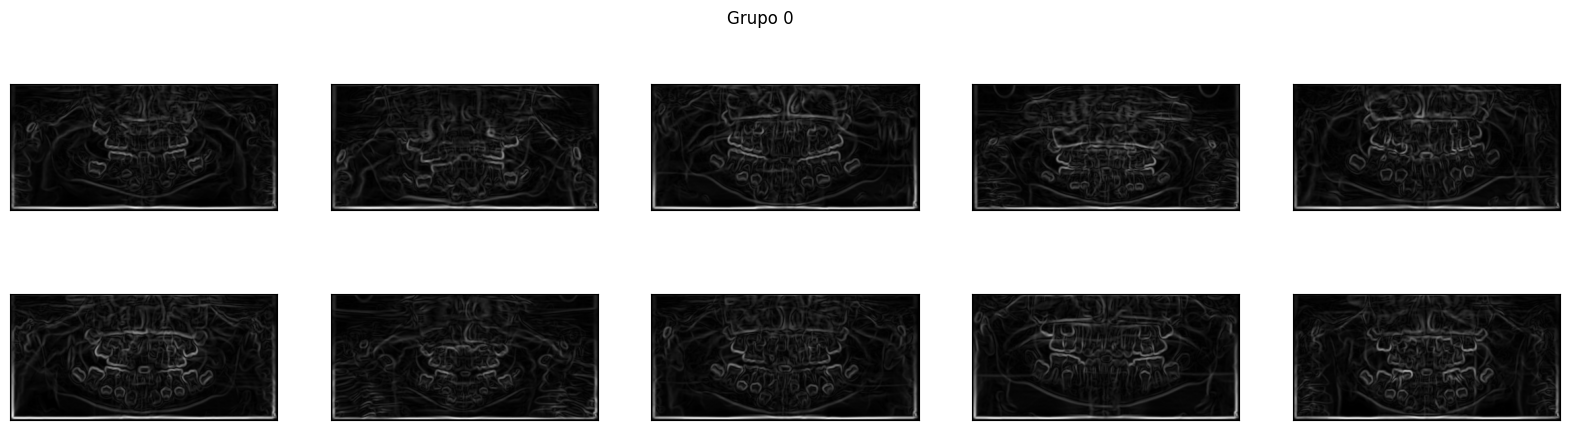

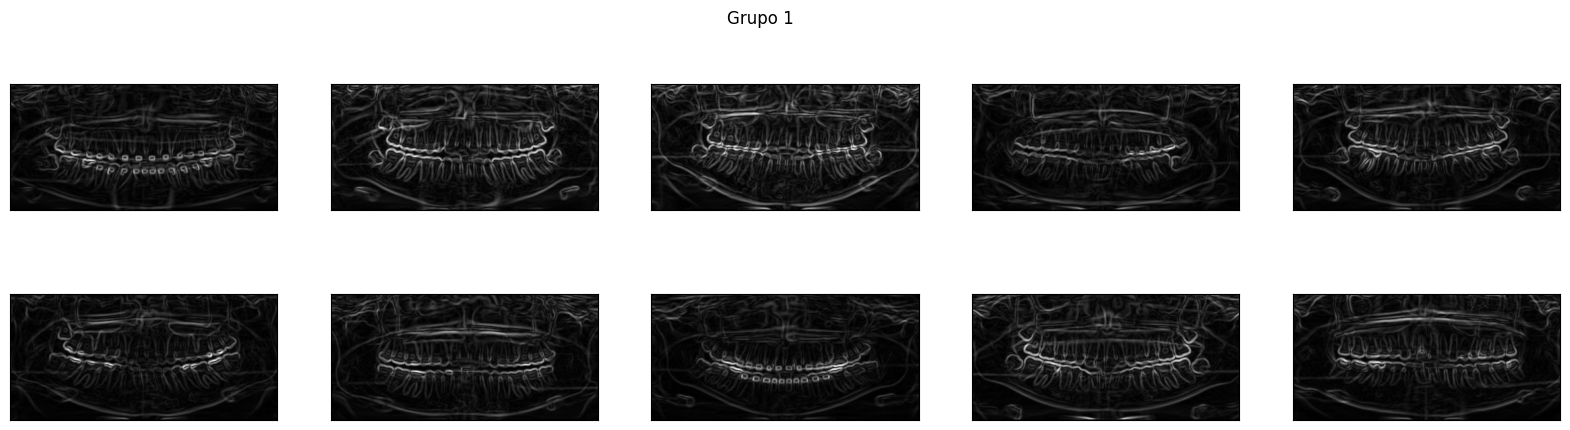

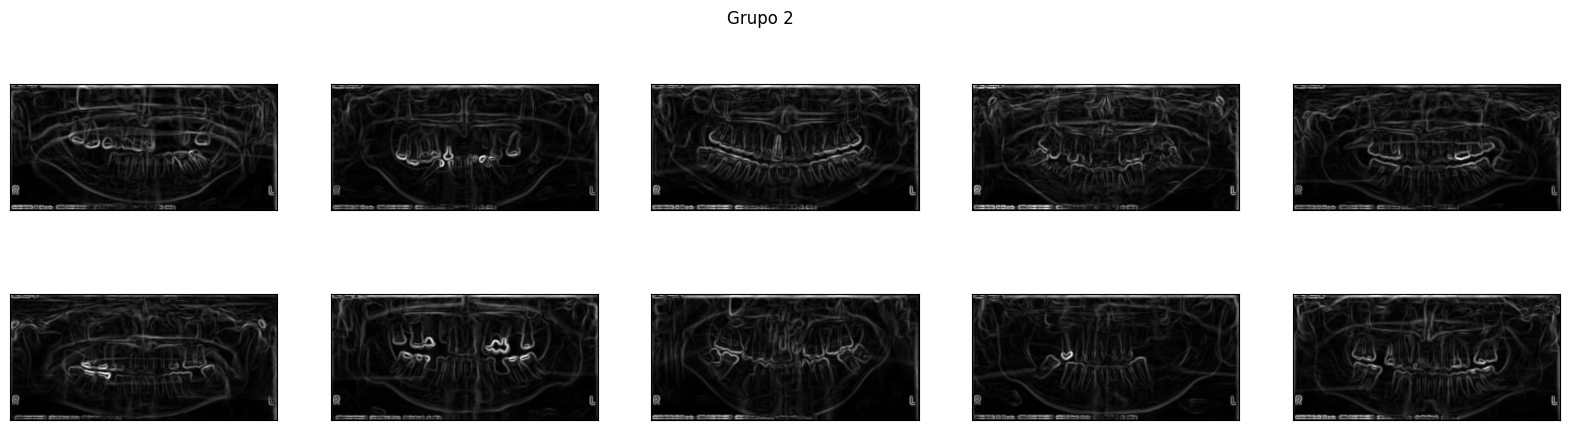

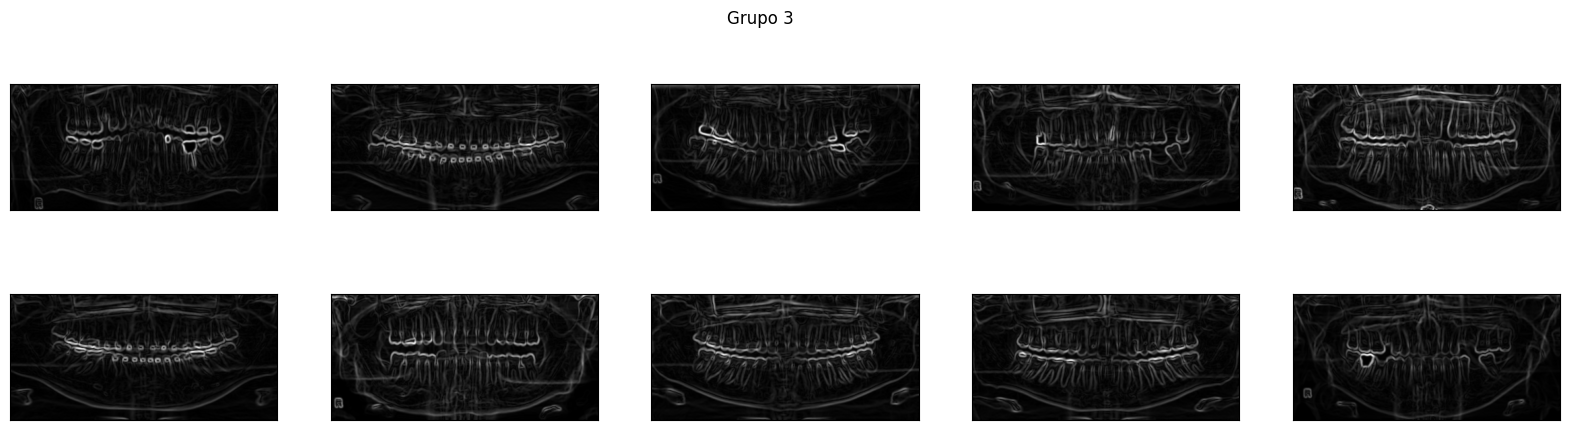

In [84]:
show_images(column='image_sabel', c_labels='kmeans_sabel_label')

## Predcción aplicando filtro sabel

In [73]:
df['image_hist'] = df['image'].apply(cv2.equalizeHist)

In [74]:
predict(column='image_hist', c_labels='kmeans_hist_label')

Cantidad de iteraciones realizadas: 12


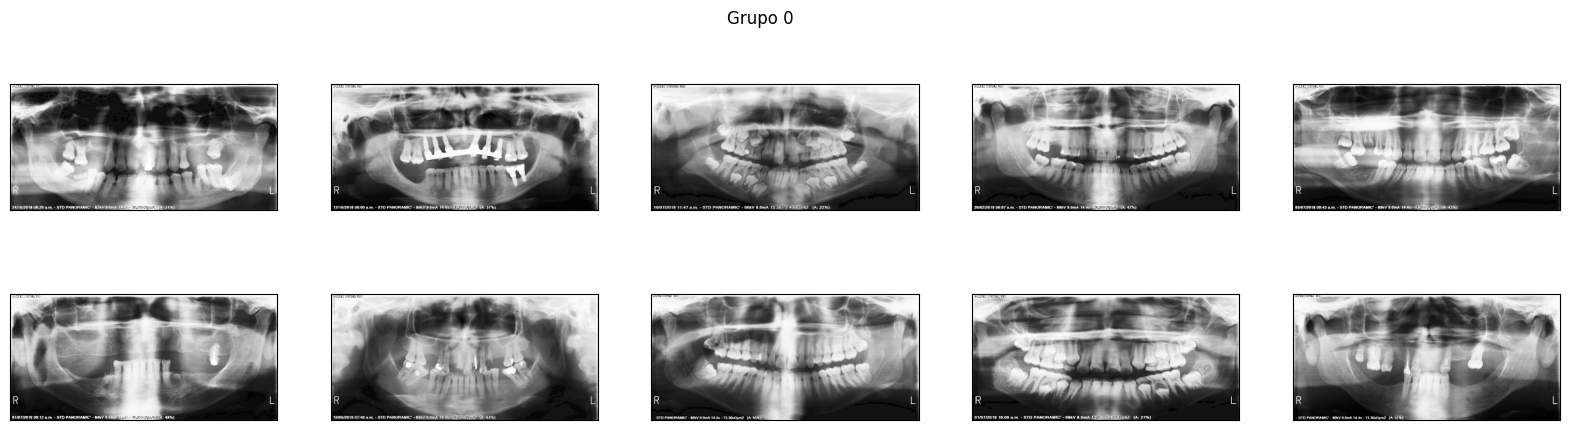

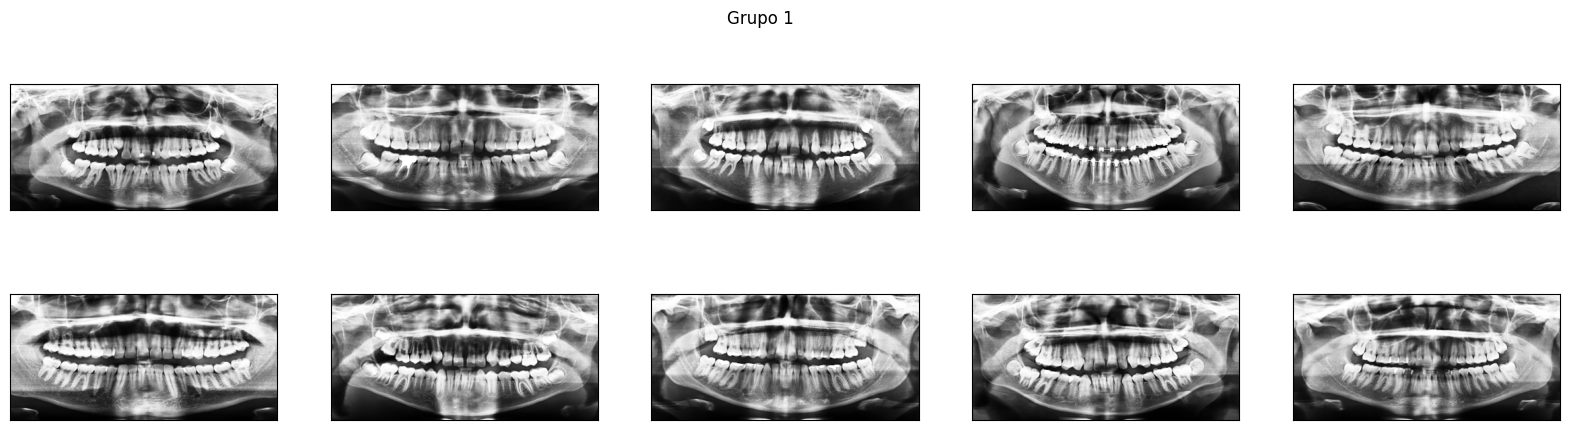

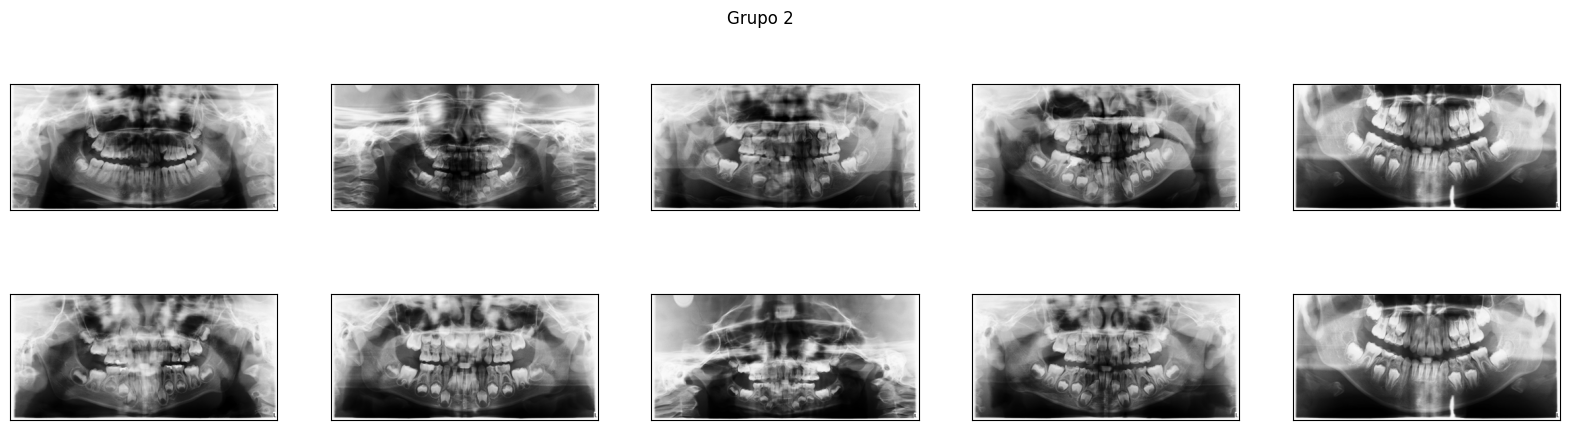

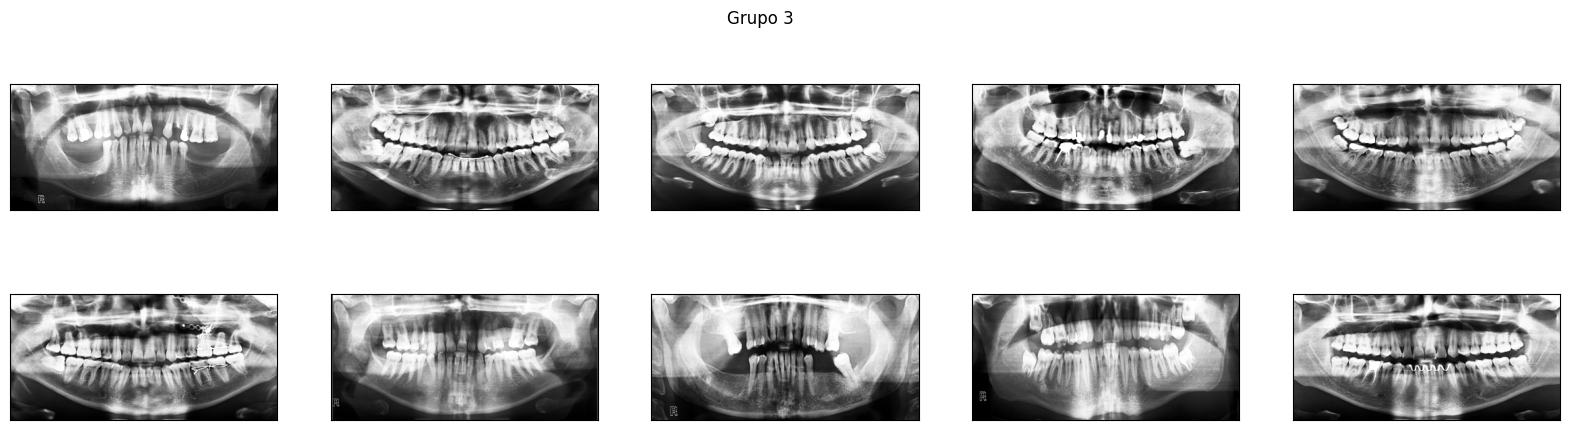

In [76]:
show_images(column='image_hist', c_labels='kmeans_hist_label')